In [45]:
import torch
import torchvision
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from matplotlib import pyplot as plt
import random
import numpy as np
import os
import glob
#TODO: failed


In [66]:
def show_img(img:torch.Tensor):
    plt.imshow(img.permute(1,2,0))

In [77]:
def get_img_from_path(path:str) -> torch.Tensor:
    size =  os.path.getsize(path)
    byte_datas = torch.from_file(path,size=size,dtype=torch.uint8)
    img = torchvision.io.decode_jpeg(byte_datas,torchvision.io.ImageReadMode.RGB)

    img = F.interpolate(img.unsqueeze(0),(64,64))
    img = img.squeeze(0)/255
    return img


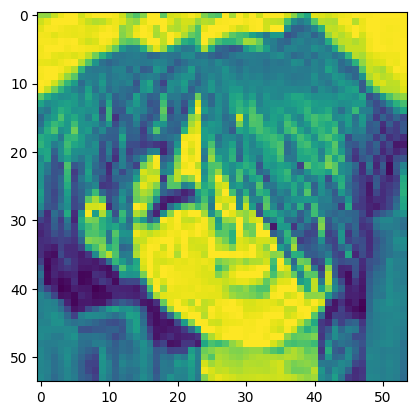

In [67]:
filepaths = glob.glob("data/AnimeFace/images/*.jpg")
img = get_img_from_path(filepaths[0])
torch.stack((get_img_from_path(filepaths[1]),img),0)
show_img(img[0].unsqueeze(0))
#img.shape,img

In [78]:
class AnimeFace(torch.utils.data.Dataset):
    def __init__(self):
        super().__init__()
        filepaths = glob.glob("data/AnimeFace/images/*.jpg")
        imgs = []
        for path in filepaths[:2000]:
            imgs.append(get_img_from_path(path=path))
        self.data =  torch.stack(imgs,0)
        self.n = len(imgs)
    def __getitem__(self, index):
        return self.data[index]
    def __len__(self):
        return self.n
    

In [89]:
dataset = AnimeFace()

In [74]:
torch.manual_seed(123)
np.random.seed(123)

In [127]:
def linear_beta_schedule(timesteps):
    beta_start = 1e-4
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

T = 1000
betas = linear_beta_schedule(T)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t).reshape(batch_size, *((1,) * (len(x_shape) - 1)))
    return out

def forward_diffusion_sample(x_0, t, device="cuda"):
    noise = torch.randn_like(x_0)
    sqrt_alphas = get_index_from_list(sqrt_alphas_cumprod.to(device), t, x_0.shape)
    sqrt_one_minus_alphas = get_index_from_list(sqrt_one_minus_alphas_cumprod.to(device), t, x_0.shape)
    return sqrt_alphas * x_0 + sqrt_one_minus_alphas * noise, noise


In [129]:
class SinusoidalPositionEmbeddings(torch.nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, timestep):
        device = timestep.device
        half_dim = self.dim // 2
        emb = np.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = timestep[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


In [135]:
from torch import nn
class Block(torch.nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()
        self.up = up
        if up:
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)

    def forward(self, x, t):
        h = self.bnorm1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))[:, :, None, None]
        h = h + time_emb
        h = self.bnorm2(self.relu(self.conv2(h)))
        return self.transform(h)

class SimpleUnet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        time_dim = 256
        self.time_embed = SinusoidalPositionEmbeddings(time_dim)

        self.block1 = Block(3, 64, time_dim)
        self.block2 = Block(64, 128, time_dim)
        self.block3 = Block(128, 128, time_dim, up=True)
        self.block4 = Block(128, 64, time_dim, up=True)
        self.output = torch.nn.Conv2d(64, 3, 1)

    def forward(self, x, t):
        t = self.time_embed(t)
        x1 = self.block1(x, t)
        x2 = self.block2(x1, t)
        x3 = self.block3(x2, t)
        x4 = self.block4(x3, t)
        return self.output(x4)


In [82]:
class VAEEncoder(torch.nn.Module):
    def __init__(self,in_channels, latent_dim):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, 64, kernel_size=4,stride= 2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128,latent_dim,kernel_size=4,stride=2, padding=1)
        )

    def forward(self,x):
        return self.encoder(x)
    
class VAEDecoder(torch.nn.Module):
    def __init__(self, latent_dim,out_channels):
        super().__init__()
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(latent_dim, 128, kernel_size=4,stride= 2, padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64,latent_dim,kernel_size=4,stride=2, padding=1)
        )

    def forward(self,x):
        return self.decoder(x)


class VAE(torch.nn.Module):
    def __init__(self,in_channels,latent_dim, out_channels):
        super().__init__()
        self.encoder = VAEEncoder(in_channels, latent_dim)
        self.decoder = VAEDecoder(latent_dim, out_channels)
    def forward(self,x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed
    


In [137]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SimpleUnet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()
dataset = AnimeFace()
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

epochs = 50

In [ ]:
torch.save(model.state_dict()) 

In [150]:


for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        batch = batch.to(device)
        t = torch.randint(0, T, (batch.size(0),), device=device).long()
        x_t, noise = forward_diffusion_sample(batch, t, device)
        noise_pred = model(x_t, t)
        loss = loss_fn(noise_pred, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}: Loss = {loss.item():.4f}")


Epoch 1/50: Loss = 0.2036
Epoch 2/50: Loss = 0.1582
Epoch 3/50: Loss = 0.2352
Epoch 4/50: Loss = 0.1651
Epoch 5/50: Loss = 0.2425
Epoch 6/50: Loss = 0.2058
Epoch 7/50: Loss = 0.1918
Epoch 8/50: Loss = 0.1698
Epoch 9/50: Loss = 0.1853
Epoch 10/50: Loss = 0.1610
Epoch 11/50: Loss = 0.1728
Epoch 12/50: Loss = 0.1979
Epoch 13/50: Loss = 0.2089
Epoch 14/50: Loss = 0.1639
Epoch 15/50: Loss = 0.1534
Epoch 16/50: Loss = 0.1888
Epoch 17/50: Loss = 0.1793
Epoch 18/50: Loss = 0.1924
Epoch 19/50: Loss = 0.1654
Epoch 20/50: Loss = 0.2004
Epoch 21/50: Loss = 0.1683
Epoch 22/50: Loss = 0.1452
Epoch 23/50: Loss = 0.1663
Epoch 24/50: Loss = 0.1993
Epoch 25/50: Loss = 0.1833
Epoch 26/50: Loss = 0.1627
Epoch 27/50: Loss = 0.1910
Epoch 28/50: Loss = 0.2358
Epoch 29/50: Loss = 0.1625
Epoch 30/50: Loss = 0.1881
Epoch 31/50: Loss = 0.1761
Epoch 32/50: Loss = 0.1529
Epoch 33/50: Loss = 0.1587
Epoch 34/50: Loss = 0.2135
Epoch 35/50: Loss = 0.1873
Epoch 36/50: Loss = 0.2297
Epoch 37/50: Loss = 0.1589
Epoch 38/5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9654269..2.170187].


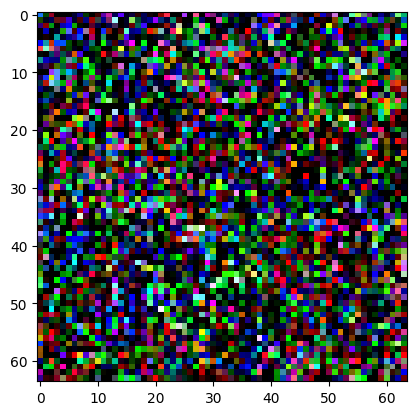

In [151]:
@torch.no_grad()
def sample_timestep(x, t):
    beta_t = get_index_from_list(betas.to(x.device), t, x.shape)
    sqrt_one_minus_alpha_cumprod = get_index_from_list(sqrt_one_minus_alphas_cumprod.to(x.device), t, x.shape)
    sqrt_recip_alpha = 1. / get_index_from_list(torch.sqrt(alphas.to(x.device)), t, x.shape)
    pred_noise = model(x, t)
    model_mean = sqrt_recip_alpha * (x - beta_t / sqrt_one_minus_alpha_cumprod * pred_noise)

    if t[0] == 0:
        return model_mean
    noise = torch.randn_like(x)
    return model_mean + torch.sqrt(beta_t) * noise

@torch.no_grad()
def sample_image():
    img = torch.randn((1, 3, 64, 64), device=device)
    for i in reversed(range(0, T)):
        t = torch.tensor([i], device=device)
        img = sample_timestep(img, t)
    return img
T =100
sample = sample_image()
show_img(sample[0].cpu())
